<font size='10'><h1 align="center"><font color='blue'>iPy oxDNA Examples</font></h1>

<center>
<img src="../../../oxDNA.png">
</center>

<font size='10'><a class="anchor" id="3"></a> <h2 align="center"> <font color='black'>Duplex Melting</font></h2> 

In [1]:
from ipy_oxdna.umbrella_sampling import MeltingUmbrellaSampling
from ipy_oxdna.oxdna_simulation import SimulationManager, Simulation, Observable
from ipy_oxdna.vmmc import *

import os
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

<font size='10'><a class="anchor" id="3"></a> <h2 align="center"> <font color='black'>Potential Energy Umbrella Temperature Interpolation</font></h2> 

In [2]:
path = os.path.abspath('/scratch/matthew/ipy_oxDNA/ipy_oxdna_examples/duplex_melting/')

system_name = 'external_force_file'

conditions = ['5']

systems = [f'duplex_52_{stiff}_test' for stiff in conditions]

file_dirs = [f'{path}/{system_name}' for _ in range(len(systems))]


xmin = 0
xmax = 15
n_windows = 56
starting_r0 = 0.4213
stiff = 5
print_every = 1e4
temperature = '52C'
name = 'all_observables.txt'

pre_eq_steps = 1e6
eq_steps = 1e7
prod_steps = 1e9

verlet_skin = 0.5

hb_contact_filename = 'hb_contacts.txt'

com_list = ','.join('8,9,10,11,12,13,14,15'.split(',')[::-1])
ref_list = '0,1,2,3,4,5,6,7'

particle_indexes = [com_list, ref_list]
hb_contact_observable = [{'idx':particle_indexes, 'name':f'{hb_contact_filename}', 'print_every':int(print_every)}]


pre_equlibration_parameters_list = [{'backend':'CPU',"CUDA_list": "no",'use_edge': 'false','steps':f'{pre_eq_steps}','print_energy_every': f'{pre_eq_steps}',
                           'print_conf_interval':f'{pre_eq_steps}', 'refresh_vel': '1',
                           'fix_diffusion': '0', 'T':f'{temperature}', 'verlet_skin': f'{verlet_skin}' }
                            for _ in conditions]

equlibration_parameters_list = [{'backend':'CPU',"CUDA_list": "no",'use_edge': 'false','steps':f'{eq_steps}','print_energy_every': f'{eq_steps}',
                           'print_conf_interval':f'{eq_steps/10}', 'refresh_vel': '1',
                           'fix_diffusion': '0', 'T':f'{temperature}', 'verlet_skin': f'{verlet_skin}'}
                            for _ in conditions]

production_parameters_list = [{'backend':'CPU',"CUDA_list": "no",'use_edge': 'false','steps':f'{prod_steps}','print_energy_every': f'{prod_steps}',
                           'print_conf_interval':f'{prod_steps/10}', 'refresh_vel': '1',
                           'fix_diffusion': '0', 'T':f'{temperature}', 'verlet_skin': f'{verlet_skin}'}
                            for _ in conditions]

us_list = [MeltingUmbrellaSampling(file_dir, sys, clean_build='force') for file_dir, sys in zip(file_dirs,systems)]
simulation_manager = SimulationManager()

In [ ]:
for us, pre_equlibration_parameters in zip(us_list, pre_equlibration_parameters_list):
    print(us.system)
    us.build_pre_equlibration_runs(simulation_manager, n_windows, com_list, ref_list,
                               stiff, xmin, xmax, pre_equlibration_parameters, starting_r0, pre_eq_steps,
                               print_every=print_every, observable=True, protein=None,
                               force_file=True, continue_run=False, name=name, custom_observable=hb_contact_observable)

In [5]:
#I need to implement a way to modify the force.js to contain group_name, where the group name of the dict is the key of item
#such that I can create objervables which output the force_energy of every individual external potential.

#Once I have done that, I will be able to use the potential energy output to the file all_observables.txt in analysis.
#I will be using a non-parametric potential energy weighting scheme

#by taking summing over the exp(-beta*(U_i - f) for each window, and then dividing by the sum of the exp(-beta*U) for all windows.

In [ ]:
simulation_manager.run(cpu_run=True, gpu_mem_block=False)

In [7]:
for us, equlibration_parameters in zip(us_list, equlibration_parameters_list):
    print(us.system)
    us.build_equlibration_runs(simulation_manager, n_windows, com_list, ref_list,
                               stiff, xmin, xmax, equlibration_parameters, print_every=print_every,
                               observable=True, protein=None, force_file=True, continue_run=False, name=name, custom_observable=hb_contact_observable)

duplex_52_5_test


In [ ]:
simulation_manager.run(cpu_run=True, gpu_mem_block=False)

In [201]:
for us, production_parameters in zip(us_list, production_parameters_list):
    print(us.system)
    us.build_production_runs(simulation_manager, n_windows, com_list, ref_list,
                             stiff, xmin, xmax, production_parameters,
                             observable=True, print_every=print_every ,protein=None,
                             force_file=True, continue_run=1e9, name=name, custom_observable=hb_contact_observable)

duplex_52_5_test


In [ ]:
simulation_manager.run(cpu_run=True, gpu_mem_block=False)

In [5]:
simulation_manager.terminate_all()

In [3]:
for us in us_list:
    us.observables_list = []
    us.initialize_observables(com_list, ref_list, print_every=print_every, name=name)

all_observables = []
for us in us_list:
    all_observables.append(us.analysis.read_all_observables('prod'))

[autoreload of ipy_oxdna.umbrella_sampling failed: Traceback (most recent call last):
  File "/home/matthew/.conda/envs/oxDNA3.3/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/home/matthew/.conda/envs/oxDNA3.3/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/home/matthew/.conda/envs/oxDNA3.3/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/scratch/matthew/ipy_oxDNA/ipy_oxdna/umbrella_sampling.py", line 1464
    for

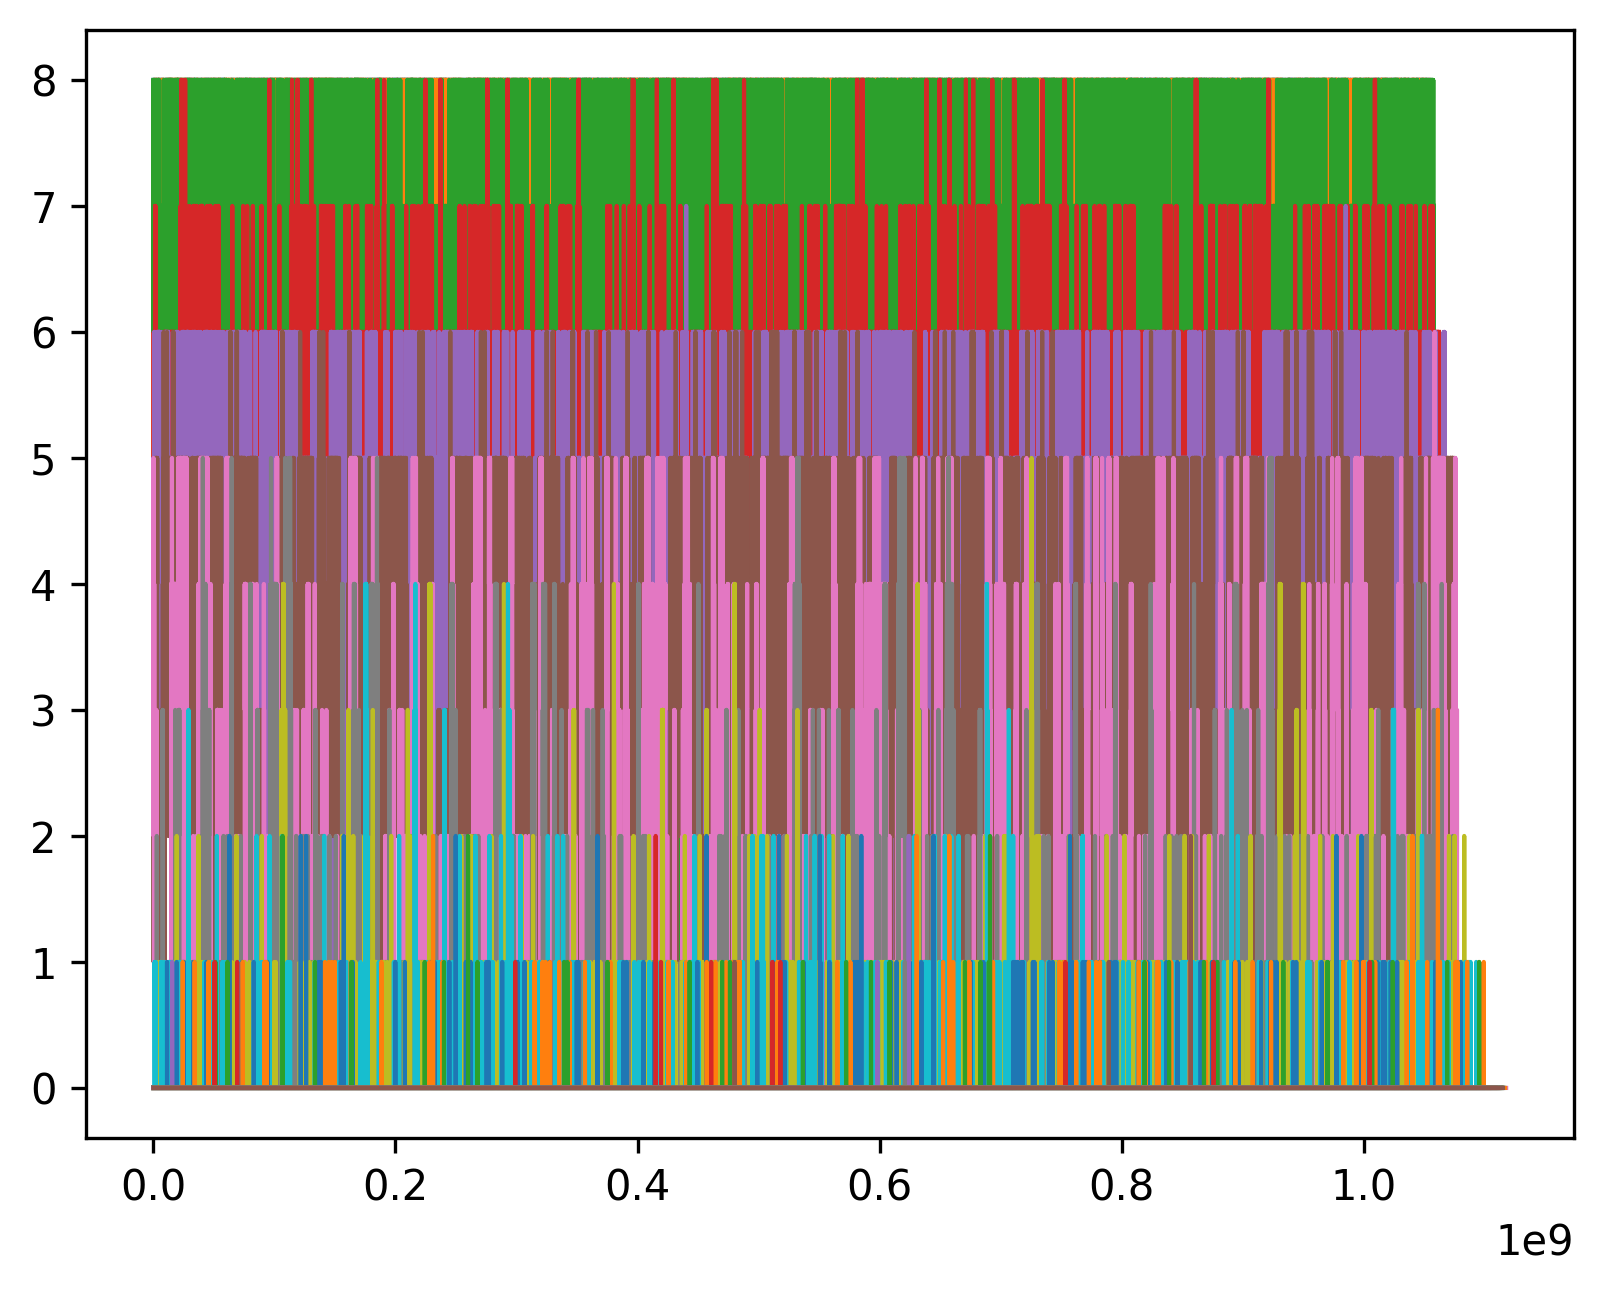

In [4]:
names = ['backbone', 'bonded_excluded_volume', 'stacking', 'nonbonded_excluded_volume', 'hydrogen_bonding', 'cross_stacking', 'coaxial_stacking', 'debye_huckel']
columns = ['com_distance', 'hb_list', 'force_energy', *names]

my_obs = all_observables[0]

fig, ax = plt.subplots(dpi=300)
for idx, obs in enumerate(my_obs):
    plt.plot(obs['steps'], obs['hb_list'].rolling(window=1).mean(), label=f'{idx}', linewidth=1)
# plt.legend(fontsize=1)

In [271]:
number_of_forces = us_list[0].get_n_external_forces()
force_energy = [f'force_energy_{idx}' for idx in range(number_of_forces)]

min_length = min([len(inner_list['com_distance']) for inner_list in us_list[0].obs_df])
force_dfs = [innerlist[force_energy][:min_length] for innerlist in us_list[0].obs_df]
force_dfs
# add_column = us_list[0].n_windows*2 - 2 + number_of_forces
# column_names  = [f'force_energy_{idx}' for idx in range(number_of_forces, add_column )]

# for idx, df in enumerate(force_dfs[1:], start=0):
#     # Create a mapping for renaming columns

#     rename_dict = {
#         df.columns[-2]: column_names[idx * 2],
#         df.columns[-1]: column_names[idx * 2 + 1]
#     }
#     # Rename the last two columns of the DataFrame
#     df.rename(columns=rename_dict, inplace=True)

# concatenated_df = pd.concat(force_dfs, axis=0).fillna(0)
# Concatenate all DataFrames
# concatenated_df = pd.concat(force_dfs, axis=1).fillna(0)

[        force_energy_0  force_energy_1  force_energy_2  force_energy_3  \
 0         1.080000e-08    5.210000e-08    1.390000e-08    8.500000e-09   
 1         1.600000e-08    1.270000e-08    8.200000e-08    3.000000e-10   
 2         3.510000e-08    8.900000e-09    4.100000e-09    5.960000e-08   
 3         1.129000e-07    1.000000e-10    3.100000e-09    1.210000e-08   
 4         6.640000e-08    5.800000e-09    7.890000e-08    6.500000e-09   
 ...                ...             ...             ...             ...   
 105486    3.400370e-05    9.950000e-08    1.580000e-08    2.000000e-10   
 105487    7.371000e-07    2.600000e-09    1.030000e-08    1.557000e-07   
 105488    5.898300e-06    6.200000e-09    4.900000e-08    8.000000e-10   
 105489    5.005190e-05    2.200000e-09    3.000000e-08    1.000000e-10   
 105490    1.840300e-05    7.500000e-09    2.370000e-08    4.020000e-08   
 
         force_energy_4  force_energy_5  force_energy_6  force_energy_7  \
 0         1.900000e-09

In [166]:
force_dfs

[        force_energy_0  force_energy_1  force_energy_2  force_energy_3  \
 0         1.080000e-08    5.210000e-08    1.390000e-08    8.500000e-09   
 1         1.600000e-08    1.270000e-08    8.200000e-08    3.000000e-10   
 2         3.510000e-08    8.900000e-09    4.100000e-09    5.960000e-08   
 3         1.129000e-07    1.000000e-10    3.100000e-09    1.210000e-08   
 4         6.640000e-08    5.800000e-09    7.890000e-08    6.500000e-09   
 ...                ...             ...             ...             ...   
 105486    3.400370e-05    9.950000e-08    1.580000e-08    2.000000e-10   
 105487    7.371000e-07    2.600000e-09    1.030000e-08    1.557000e-07   
 105488    5.898300e-06    6.200000e-09    4.900000e-08    8.000000e-10   
 105489    5.005190e-05    2.200000e-09    3.000000e-08    1.000000e-10   
 105490    1.840300e-05    7.500000e-09    2.370000e-08    4.020000e-08   
 
         force_energy_4  force_energy_5  force_energy_6  force_energy_7  \
 0         1.900000e-09

In [260]:
w_i = us_list[0].weight_sample(epsilon=1e-7)



223375063.93792537
0.01038314413077581
0.002869365787483308
0.00187613978213785
0.0015262467447181918
0.0011434957008430412
0.0008115087441269535
0.0008737719605383743
0.001075003268053115
0.001267759865504479
0.0014373110057701987
0.0015671332333545961
0.0016971431726538607
0.001789499073760038
0.0018085295196245948
0.0017624876899174323
0.0016974152491875186
0.001579308478214603
0.0014256442851817742
0.0012542374790044143
0.0010957656239383336
0.0009470865581413281
0.0008053490683229969
0.000675796520026424
0.0005611025562205704
0.0004620215200476681
0.0003780317544479356
0.0003078673057949864
0.00024990856895765884
0.0002024431233093038
0.0001640103290527599
0.00013290767010896987
0.0001076838037958848
8.730340589645919e-05
7.087848707479014e-05
5.766238725532502e-05
4.7043916384822276e-05
3.857867927674688e-05
3.1767530897914426e-05
2.6278536654111145e-05
2.1846004314249323e-05
1.8257751580430526e-05
1.5344596033913666e-05
1.2971774455139418e-05
1.103199448479475e-05
9.439842623859

In [227]:


min_length = min([len(inner_list['com_distance']) for inner_list in us_list[0].obs_df])        
truncated_com_distance = pd.concat([inner_list['com_distance'][:min_length] for inner_list in us_list[0].obs_df]).reset_index(drop=True)
r0_list = us_list[0].r0

com_grid, r0_grid = np.meshgrid(truncated_com_distance, r0_list)

result = force_potential_energy(r0_grid, com_grid)

number_of_forces = us_list[0].get_n_external_forces()
force_energy = [f'force_energy_{idx}' for idx in range(number_of_forces)]

min_length = min([len(inner_list['com_distance']) for inner_list in us_list[0].obs_df])
force_dfs = [innerlist[force_energy][:min_length] for innerlist in us_list[0].obs_df]

wont_work = np.concatenate([result,result, np.array(np.concatenate(force_dfs))[:, :16].T])
data_with_biases =  wont_work.T 
data_with_biases[:, 17:] = data_with_biases[:, 17:] / 16

In [203]:
np.exp(e_to_fi_beta * e_to_neg_u_beta)

(105491, 56)

In [200]:
e_to_neg_u_beta

(105491, 56)

In [189]:
number_of_forces = us_list[0].get_n_external_forces()
force_energy = [f'force_energy_{idx}' for idx in range(number_of_forces)]

min_length = min([len(inner_list['com_distance']) for inner_list in us_list[0].obs_df])
force_dfs = [innerlist[force_energy][:min_length] for innerlist in us_list[0].obs_df]
# concat_dfs = pd.concat(force_dfs).reset_index(drop=True)
# force_df_combined = np.array(force_dfs).T




array([[3.90302000e-05, 9.60510540e-03, 3.68468818e-02, ...,
        9.72826638e-02, 8.79412708e-02, 9.59014924e-02],
       [2.12014000e-05, 4.16155200e-04, 4.68460640e-02, ...,
        8.89771760e-02, 9.73956752e-02, 9.56365198e-02],
       [4.64731800e-03, 1.90315458e-02, 2.50101680e-02, ...,
        9.04006518e-02, 1.00969723e-01, 9.58198884e-02],
       ...,
       [3.54164000e-05, 6.01655120e-03, 2.17410118e-02, ...,
        8.85994002e-02, 8.79564964e-02, 9.56102090e-02],
       [6.61823440e-03, 3.25382600e-04, 2.94595020e-02, ...,
        1.02869125e-01, 9.64454944e-02, 9.83780660e-02],
       [1.93687546e-02, 4.68020000e-05, 2.40629160e-03, ...,
        8.96044744e-02, 9.83989810e-02, 9.96308812e-02]])

/tmp/ipykernel_2023159/1517859950.py:8: RuntimeWarning: divide by zero encountered in log
  free = -np.log(H)


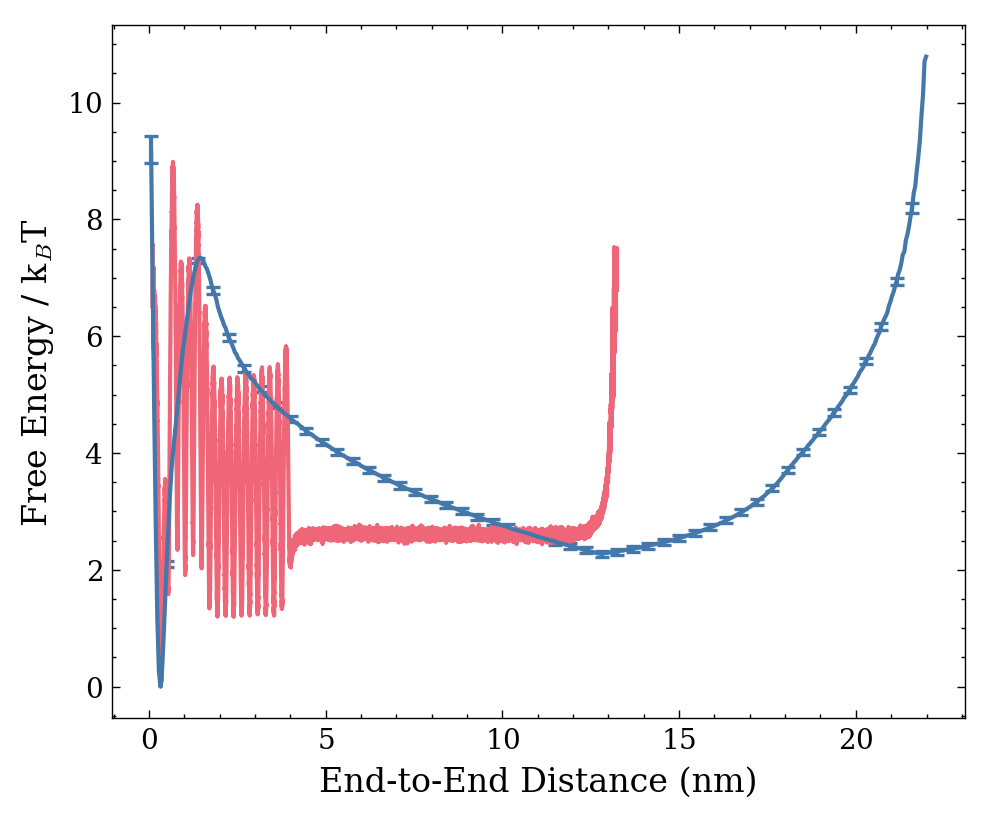

In [270]:

temperature = us_list[0].temperature
beta = 1/(temperature)
min_length = min([len(inner_list['com_distance']) for inner_list in us_list[0].obs_df])        
truncated_com_distance = pd.concat([inner_list['com_distance'][:min_length] for inner_list in us_list[0].obs_df]).reset_index(drop=True)

H, bins = np.histogram(truncated_com_distance, weights=w_i, bins=10000)

free = -np.log(H)
free = free - np.min(free)

end_truncate = 2
start_truncate = 1

ax = us_list[0].wham.plt_fig()


vmmc_replica_generator.plot_mean_free_energy_with_error_bars(num_bins=500, ax=ax, confidence_level=0.95, label='VMMC discrete made continuous 52C')
ax.plot(bins[start_truncate:-end_truncate]*0.8518, free[start_truncate-1:-end_truncate])

In [69]:
truncated_hb_list

0          8.0
1          8.0
2          8.0
3          8.0
4          8.0
          ... 
5907491    0.0
5907492    0.0
5907493    0.0
5907494    0.0
5907495    0.0
Name: hb_list, Length: 5907496, dtype: float64

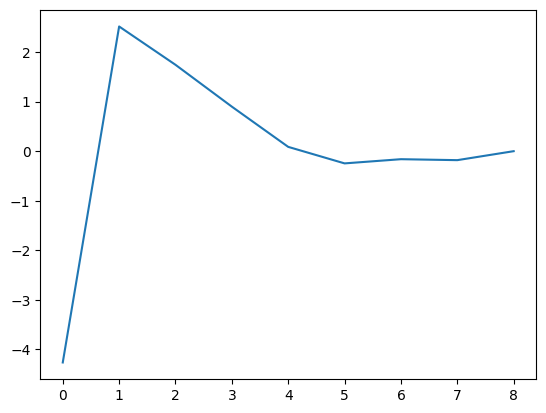

In [93]:

temperature = us_list[0].temperature
beta = 1/(temperature)
min_length = min([len(inner_list['hb_list']) for inner_list in us_list[0].obs_df])        
truncated_hb_list = pd.concat([inner_list['hb_list'][:min_length] for inner_list in us_list[0].obs_df]).reset_index(drop=True)

bins = [0,1,2,3,4,5,6,7,8,9]
H, bins = np.histogram(truncated_hb_list, weights=w_i, bins=bins)

H = H/np.sum(H)

free = -np.log(H)
free = free - free[-1]

end_truncate = 50
start_truncate = 6

plt.plot(bins[:-1], free)

In [94]:
H

array([0.91943753, 0.0010432 , 0.00226092, 0.00526242, 0.01184993,
       0.01653663, 0.01519414, 0.01549075, 0.01292448])

(-0.05, 1.05)

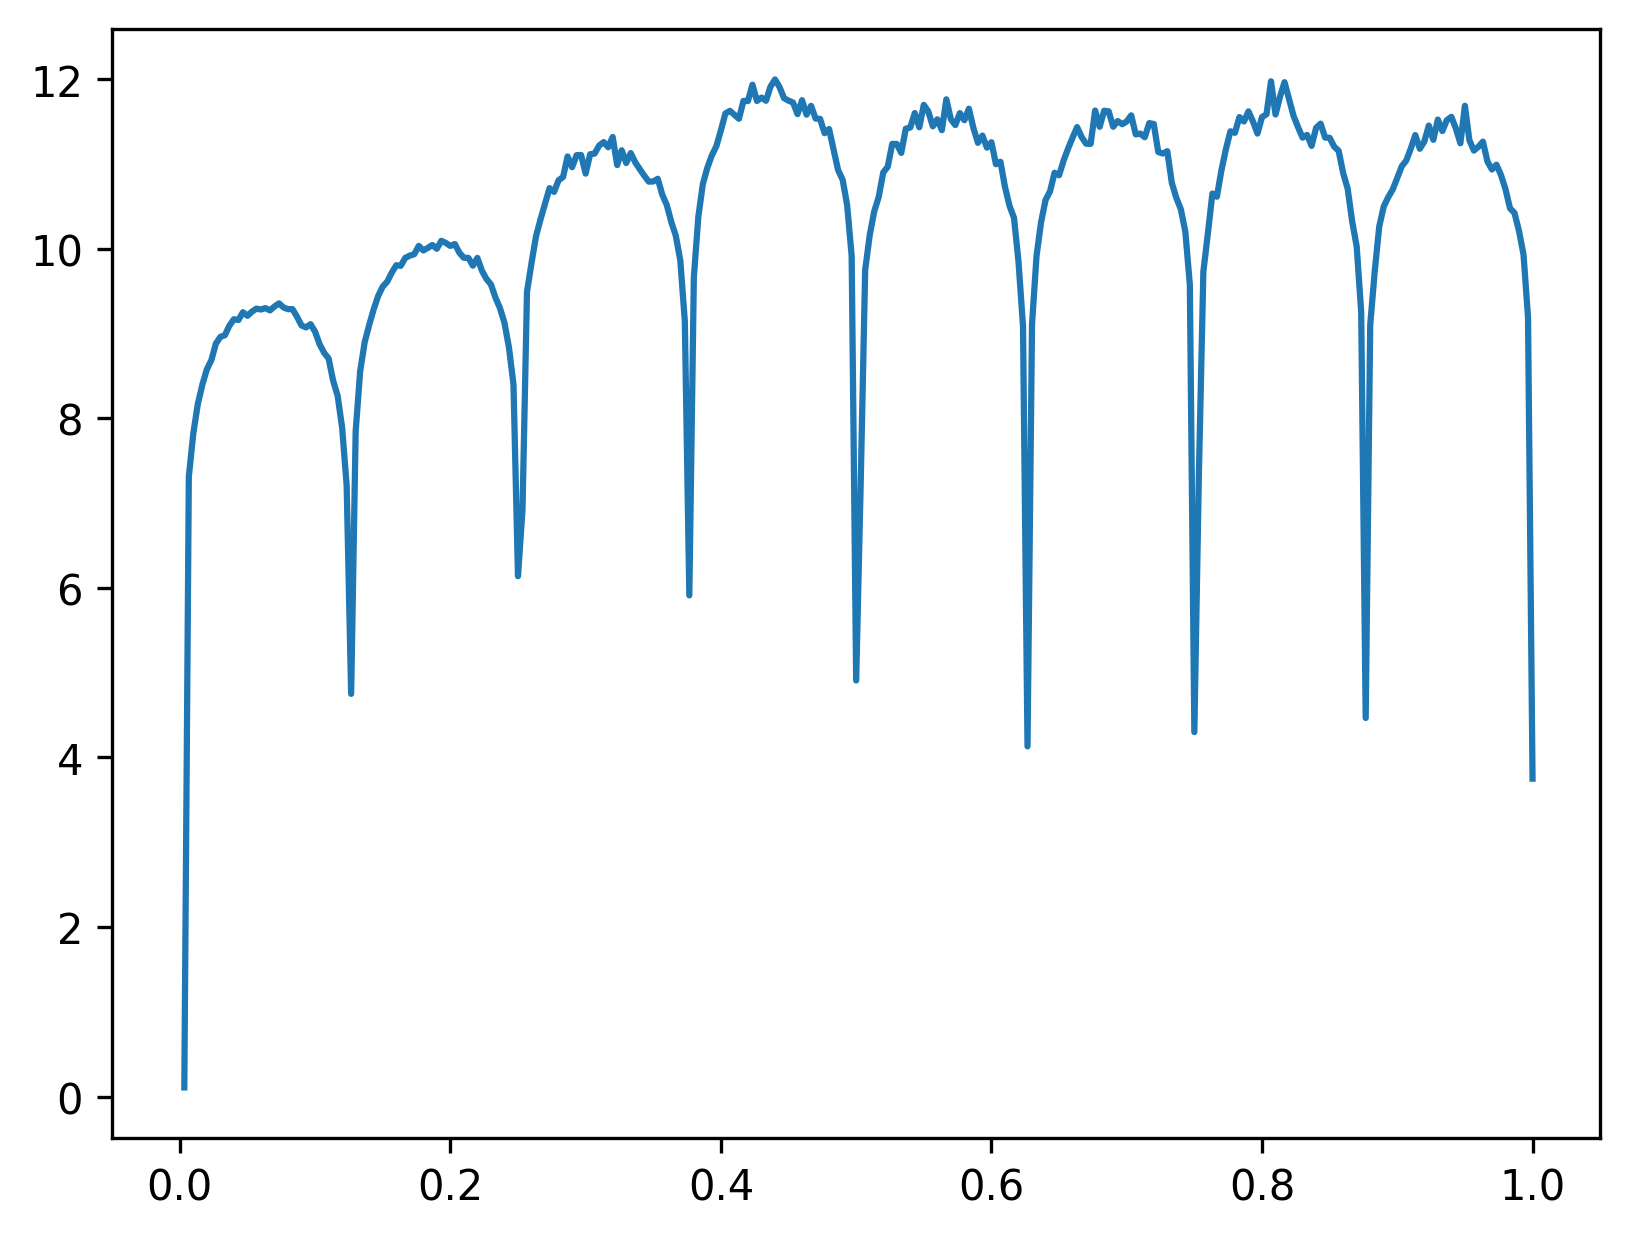

In [92]:
us_list[0].read_hb_contacts(sim_type='prod')

min_len = min([len(inner_list) for inner_list in us_list[0].hb_contacts_by_window.values()])
truncated_hb_contacts_by_window = np.array([value[:min_len] for value in us_list[0].hb_contacts_by_window.values()]).squeeze()
truncated_hb_contacts_by_window = np.concatenate(truncated_hb_contacts_by_window)


fig, ax = plt.subplots(dpi=300)

H, bins = np.histogram(truncated_hb_contacts_by_window, bins=300, weights=w_i)

ax.plot(bins[1:], -np.log(H))
ax.set_xlim(-0.05, 1.05)

/home/matthew/.conda/envs/oxDNA3.3/lib/python3.10/site-packages/numpy/lib/histograms.py:295: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  weights = np.asarray(weights)


ValueError: weights should have the same shape as a.

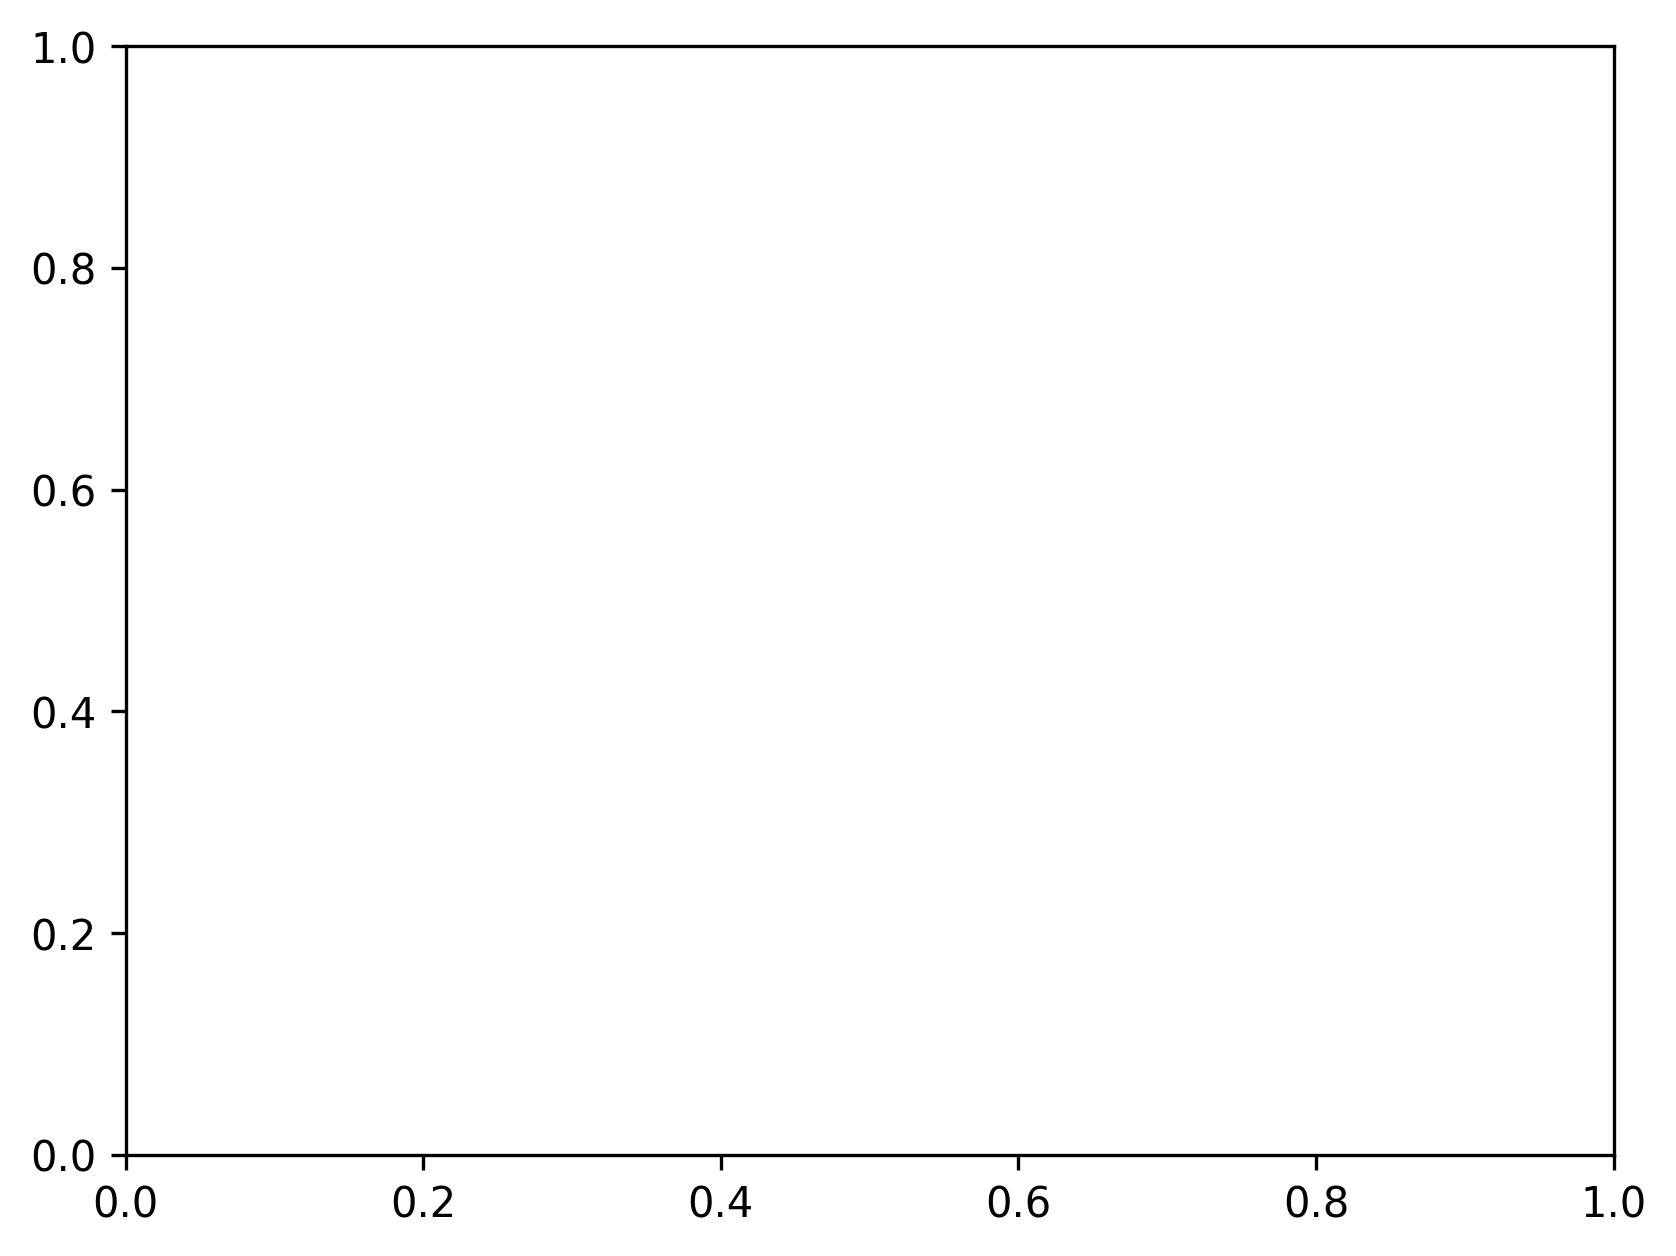

In [14]:
us_list[0].read_hb_contacts(sim_type='prod')

min_len = min([len(inner_list) for inner_list in us_list[0].hb_contacts_by_window.values()])
truncated_hb_contacts_by_window = np.array([value[:min_len] for value in us_list[0].hb_contacts_by_window.values()]).squeeze()

fig, ax = plt.subplots(dpi=300)
for hb_contacts in truncated_hb_contacts_by_window:
    
    H, bins = np.histogram(hb_contacts, bins=300, weights=w_i)
    ax.plot(bins[1:], H)
ax.set_xlim(-0.05, 1.05)

In [ ]:
for sim in us_list[0].pre_equlibration_sims[::5]:
    sim.analysis.view_last()

In [122]:
xmin = 0
xmax = 15
# temp_range = np.linspace(45, 65, 41)
temp_range = np.array([52])
# temp_range = np.array([20, 30, 40, 45, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 70, 80])
n_bins = 200
max_hb = 8
epsilon = 1e-9
convergence_slice = 1

us_list[0].wham_cont_and_disc_temp_interp_converg_analysis(convergence_slice, temp_range,
                                                           n_bins, xmin, xmax,max_hb,
                                                           epsilon=epsilon, reread_files=False,
                                                           all_observables=True)

WHAM | 12000/? [00:01<00:00, 8318.04it/s, Convergence: 0.0000000013 / 1e-09]
/scratch/matthew/ipy_oxDNA/ipy_oxdna/umbrella_sampling.py:1165: RuntimeWarning: divide by zero encountered in log
  


Converged in [12286] iterations
52.0


/home/matthew/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


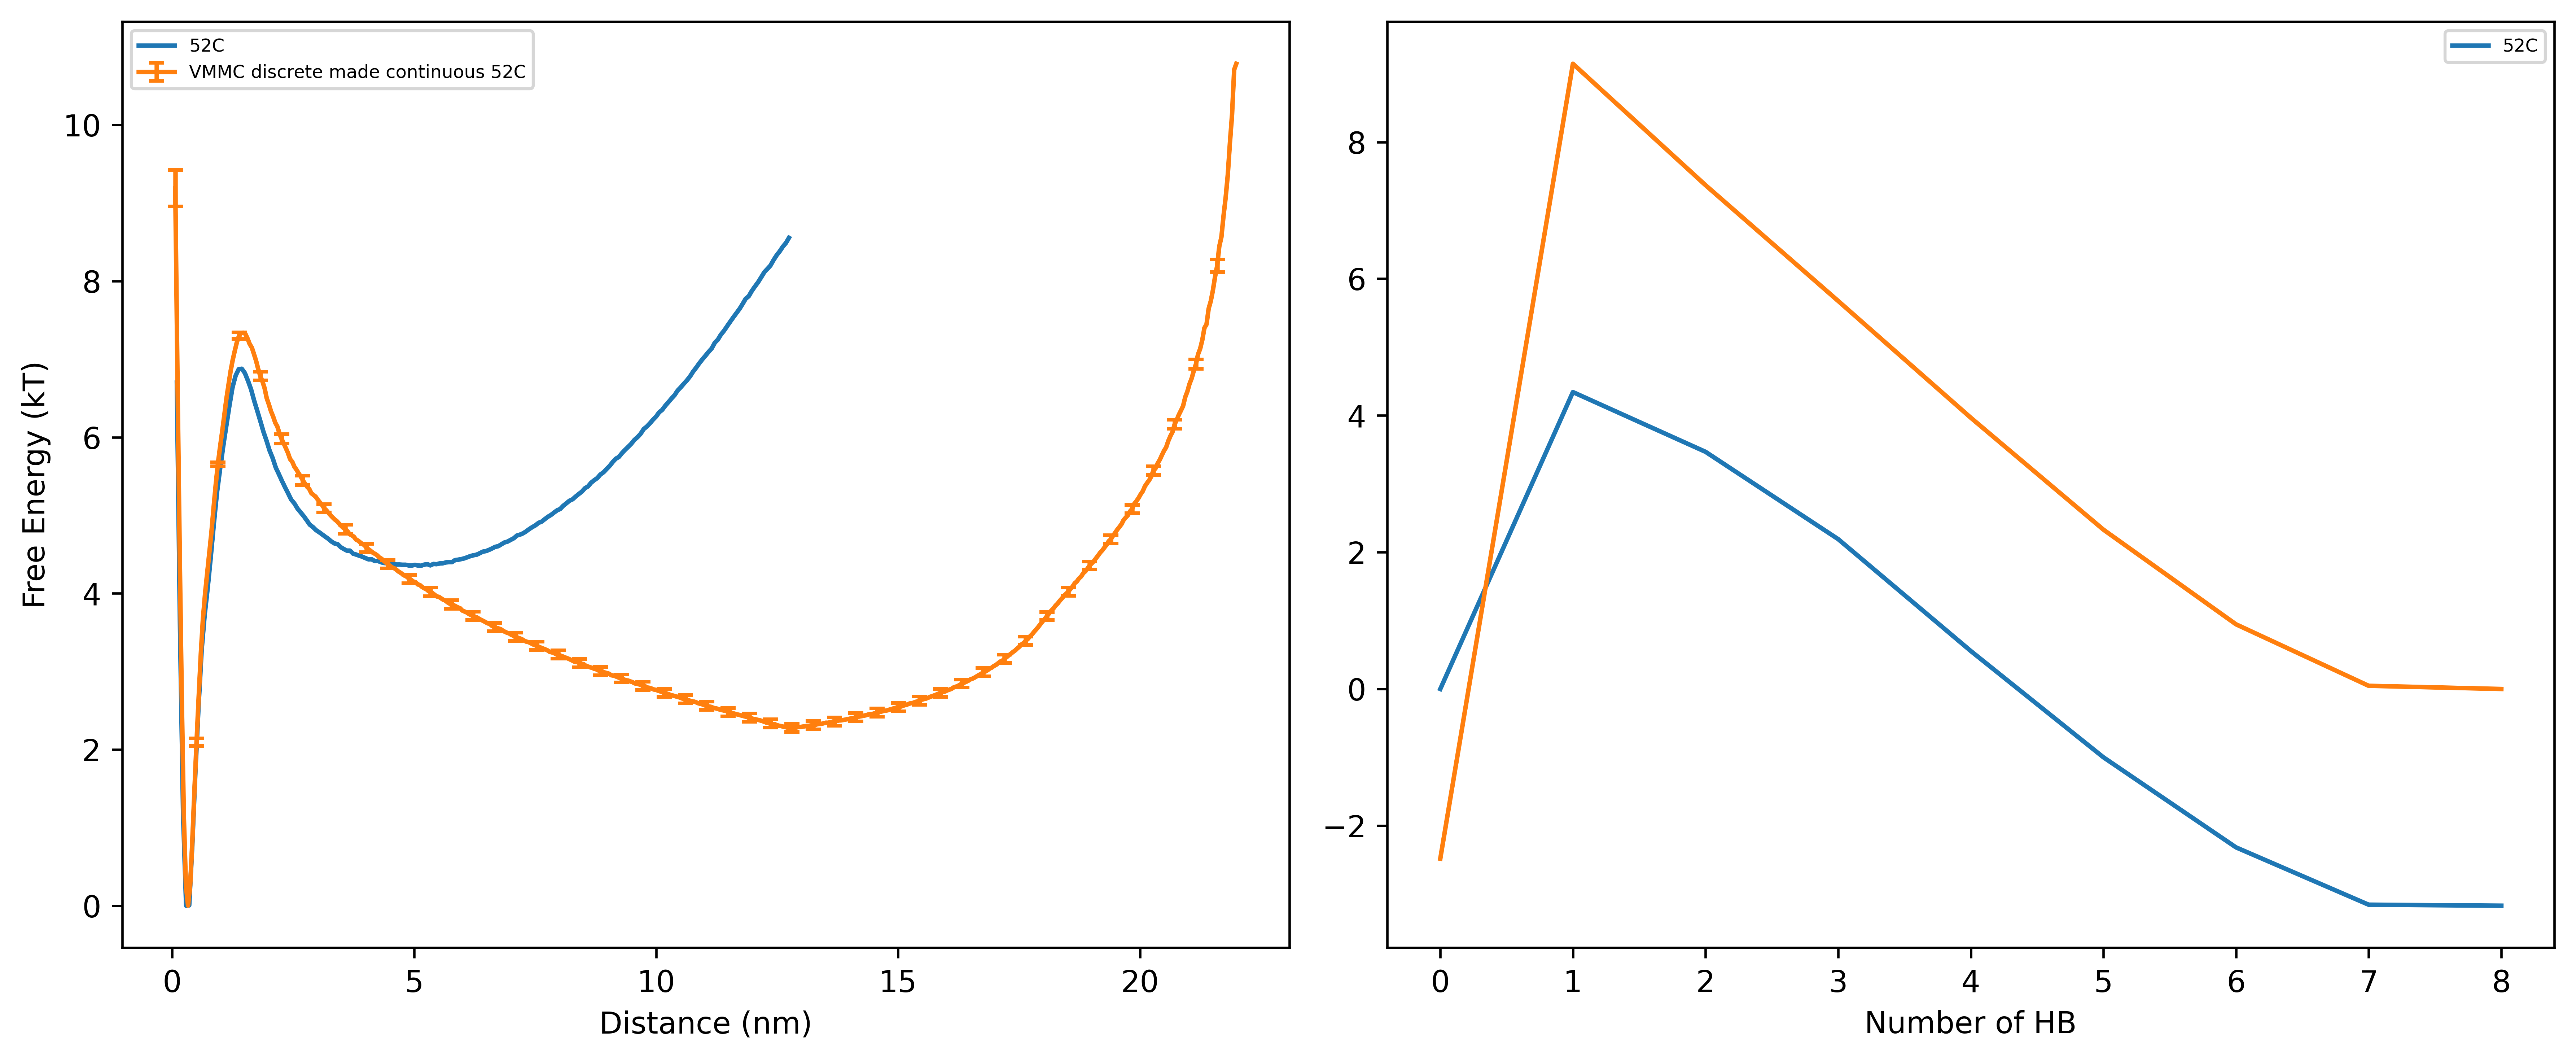

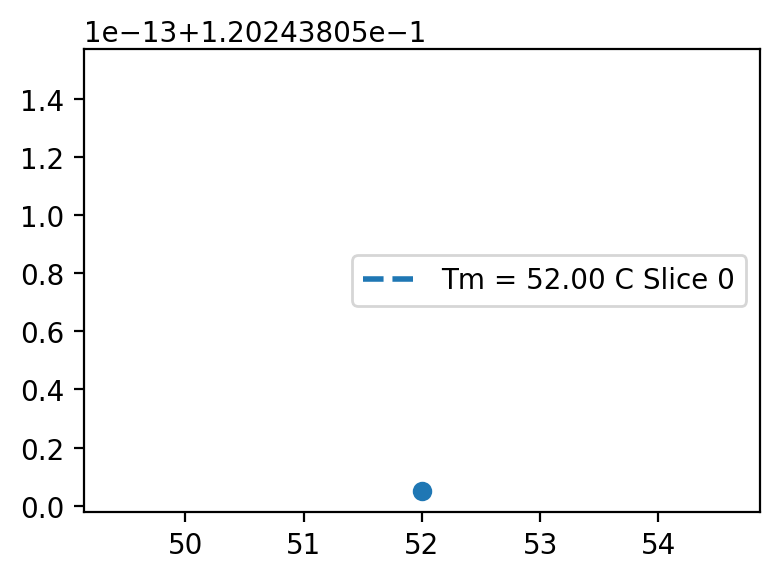

In [123]:
calculated_bin_centers, bin_edges = us_list[0].get_bins(xmin, xmax, n_bins=n_bins)

fig, (ax1, ax2) = plt.subplots(1,2, dpi=600, figsize=(12,5), tight_layout=True)
fig, ax = plt.subplots(dpi=200, figsize=(4,3), tight_layout=True)

ax1.set_xlabel('Distance (nm)')
ax2.set_xlabel('Number of HB')

ax1.set_ylabel('Free Energy (kT)')
# ax2.set_ylabel('Free Energy (kT)')

# ax1.set_xlim(-0.6,14.5)
# ax2.set_xlim(-0.6,29)
# ax1.set_ylim(-0.6,20)

for idx, free in enumerate(us_list[0].convergence_free):            
    sub_index = free[0].argmin()
    for f, temp_val in zip(free, temp_range):
        if idx == 0:
            ax1.plot(calculated_bin_centers*0.8518, f - f[sub_index], label=f'{temp_val}C') 
        else:
            ax1.plot(calculated_bin_centers*0.8518, f - f[sub_index])
vmmc_replica_generator.plot_mean_free_energy_with_error_bars(num_bins=500, ax=ax1, confidence_level=0.95, label='VMMC discrete made continuous 52C')

        
ax1.legend(fontsize=6)


for idx, free_discrete in enumerate(us_list[0].convergence_discrete_free_energy):
    for f_discrete, temp_val in zip(free_discrete, temp_range):
        if idx == 0:
            ax2.plot(range(max_hb+1), f_discrete - f_discrete[0], label=f'{temp_val}C')
        else:
            ax2.plot(range(max_hb+1), f_discrete - f_discrete[0])
ax2.legend(fontsize=6)
ax2.plot(range(9), vmmc_sim_list[0].statistics['wt_free'] - vmmc_sim_list[0].statistics['wt_free'].values[-1])
label = ''

for idx, (inverted_finfs, x_fit, y_fit, Tm) in enumerate(zip(us_list[0].convergence_inverted_finfs, us_list[0].convergence_x_fit, us_list[0].convergence_y_fit, us_list[0].convergence_Tm)):
    ax.scatter(temp_range, inverted_finfs, marker='o')
    ax.plot(x_fit, y_fit, linestyle='--', linewidth=2, label=f'Tm = {Tm:.2f} C Slice {idx}')
    # ax.axvline(x=Tm, color='r', linestyle='--', linewidth=2, label=f'{label}Tm = {Tm:.2f} °C')
    ax.legend()   

In [19]:
wham_dir = os.path.abspath('/scratch/matthew/ipy_oxDNA/wham/wham')
n_bins = '400'
tol = '1e-5'
n_boot = '0'


xmin = [0]
xmax = [15]
n_windows = 56
stiff = 5
print_every = 1e4
temperature = '52C'
name = 'all_observables.txt'

pre_eq_steps = 1e6
eq_steps = 1e8
prod_steps = 1e9

for us in us_list:
    us.observables_list = []
    us.initialize_observables(com_list, ref_list, print_every=print_every, name=name)

for us, xmi, xma  in zip(us_list, xmin, xmax):
    us.wham_run(wham_dir, xmi, xma, stiff, n_bins, tol, n_boot, all_observables=True)
    
n_chunks = 2
data_added_per_iteration = 2

for us, xmi, xma  in zip(us_list, xmin, xmax):
    us.wham.get_n_data_per_com_file()
    us.convergence_analysis(n_chunks, data_added_per_iteration, wham_dir, xmi, xma, stiff, n_bins, tol, n_boot)

Running WHAM analysis...
WHAM analysis completed
[0, 1919, 3838]
Running WHAM analysis...
WHAM analysis completed
Running WHAM analysis...
WHAM analysis completed
chunk convergence analysis
[0, 1919, 3838]
Running WHAM analysis...
WHAM analysis completed
Running WHAM analysis...
WHAM analysis completed
chunk convergence analysis


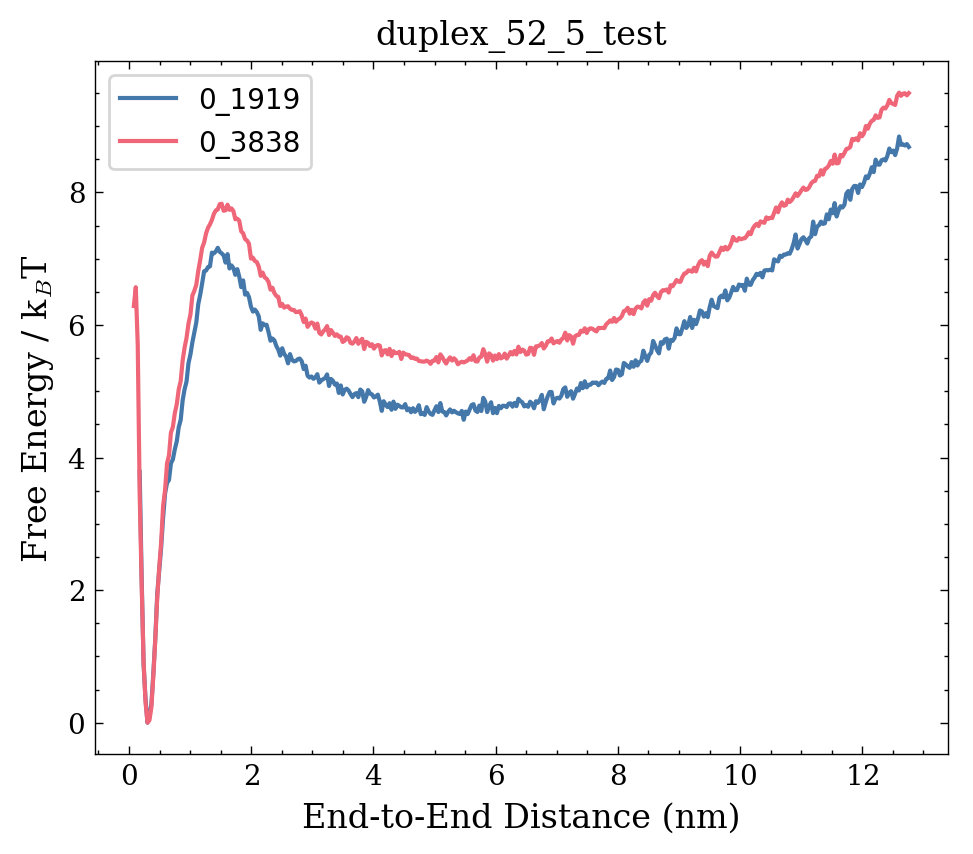

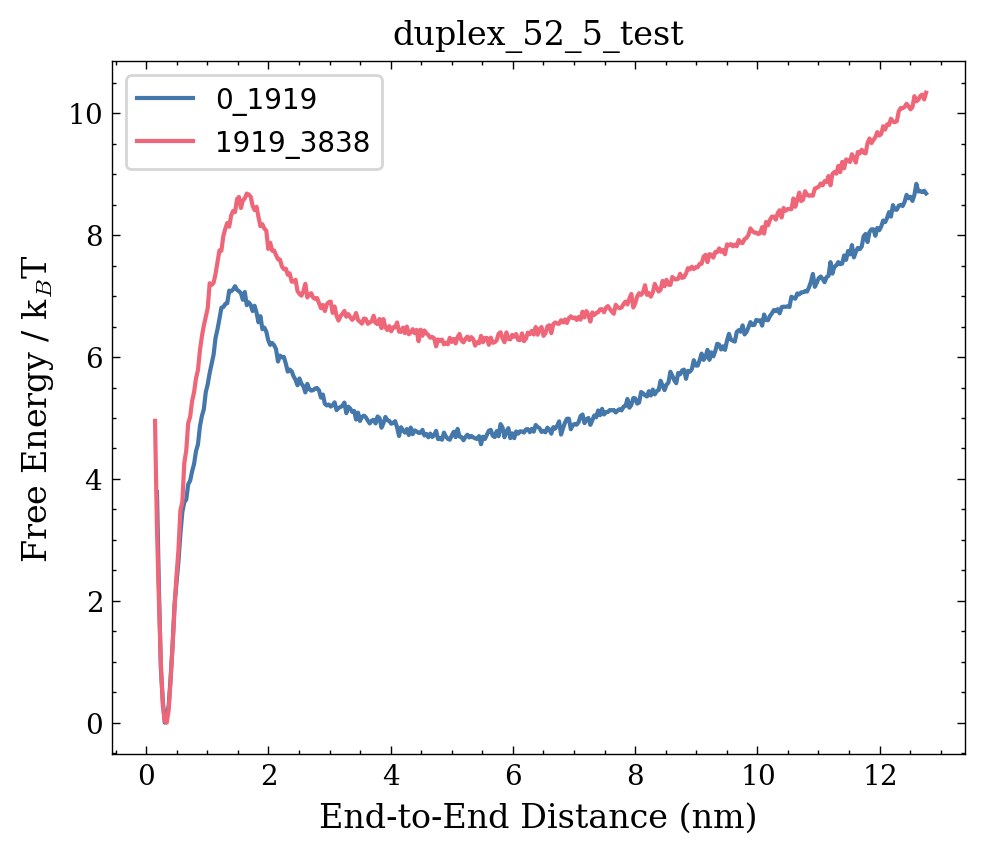

In [20]:
for us in us_list:
    us.wham.plot_truncated_free_energy()
    plt.legend()
    plt.title(us.system)
    us.wham.plot_chunks_free_energy()
    plt.legend()
    plt.title(us.system)

<font size='7'><a class="anchor" id="3"></a> <h2 align="center"> <font color='black'>Initalize Vmmc Replicas</font></h2> 

In [102]:
path = os.path.abspath('/scratch/matthew/ipy_oxDNA/ipy_oxdna_examples')
systems = ['duplex_melting']

file_dir_list = [f'{path}/{sys}' for sys in systems]
sim_dir_list = [f'{file_dir}/vmmc_melting_replicas/vmmc_melting_rep' for sys, file_dir in zip(systems, file_dir_list)]

n_replicas = 40
vmmc_replica_generator = VmmcReplicas()

vmmc_replica_generator.multisystem_replica(
    systems,
    n_replicas,
    file_dir_list,
    sim_dir_list
)
vmmc_sim_list = vmmc_replica_generator.sim_list
queue_of_simulations = vmmc_replica_generator.queue_of_sims

p1 = '15,14,13,12,11,10,9,8'
p2 = '0,1,2,3,4,5,6,7'
pre_defined_weights = [8, 16204, 1882.94, 359.746, 52.5898, 15.0591, 7.21252, 2.2498, 2.89783]

sim_parameters = {'T':'52C', 'steps':'1e9','print_energy_every': '1e5','print_conf_interval':'1e6'}

In [103]:
vmmc_sim_list[0].analysis.read_vmmc_op_data()
vmmc_sim_list[0].analysis.calculate_sampling_and_probabilities()


In [ ]:
vmmc_replica_generator

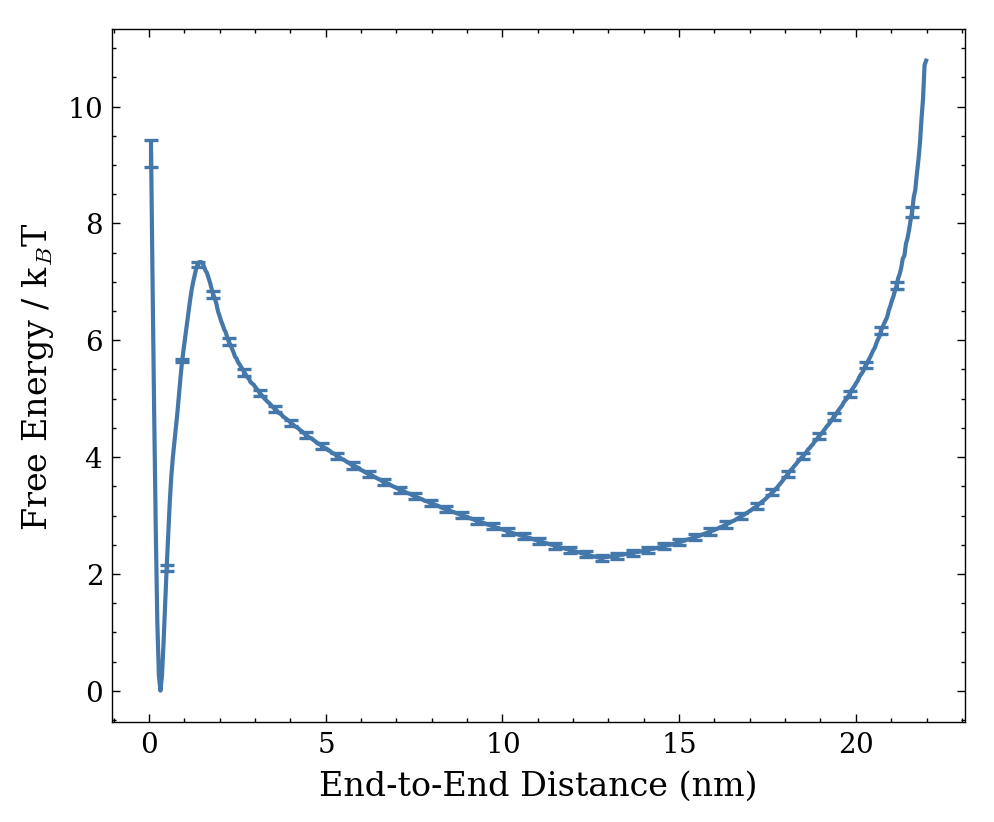

In [14]:
ax = us_list[0].wham.plt_fig()
vmmc_replica_generator.plot_mean_free_energy_with_error_bars(num_bins=500, ax=ax, confidence_level=0.95, label='VMMC discrete made continuous 52C')


In [ ]:
with plt.style.context(['science', 'no-latex', 'bright']):
    ax = us.wham.plt_fig() 
    vmmc_replica_generator.plot_mean_free_energy_with_error_bars(num_bins=500, ax=ax, confidence_level=0.95, label='VMMC discrete made continuous 52C')
    # us_1.wham.plot_free_energy(confidence_level=0.99, ax=ax, errorevery=10, label='Continuous umbrella sampling 52C all bonds')
    us.wham.plot_free_energy(confidence_level=0.99, ax=ax, errorevery=10, label='Continuos umbrella sampling 52C only intended bonds')
    ax.set_xlim(-0.1,8)
    plt.ylim(-0.1,9)
plt.legend(fontsize=6)

In [ ]:
with plt.style.context(['science', 'no-latex', 'bright']):
    ax = us.wham.plt_fig() 
    # vmmc_replica_generator.plot_mean_free_energy_with_error_bars(num_bins=500, ax=ax, confidence_level=0.95, label='VMMC discrete made continuous 52C')
    us_1.wham.plot_free_energy(confidence_level=0.99, ax=ax, errorevery=10, label='Continuous umbrella sampling 52C all bonds')
    us.wham.plot_free_energy(confidence_level=0.99, ax=ax, errorevery=10, label='Continuos umbrella sampling 52C only intended bonds')
    # ax.set_xlim(-0.1,8)
    # plt.ylim(-0.1,9)
plt.legend(fontsize=6)